In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
from Cores import Cores
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

from MEM_class import MEM


In [2]:
coreNames = ['B16', 'B17','B18','B19','B20','B21','B22','B23','B26','B27','B28','B29','B30']

DEPy = [False,False,True,True,True,False,True,True,False,False,False,False,False]
ECMy = [True,False,True,False,False,True,False,False,False,False,False,False,False]
DEP_Names = ['B18','B19','B20','B22','B23']
ECM_Names = ['B16','B18','B21']
ECM_DEPCores = []


In [3]:
idx_chosen = [3,6,7]
dfs_LT = []

j = 0
for i in idx_chosen:
    core = coreNames[i]
    dens = pd.read_excel('DepthDensity_Bcores_lowRes.xlsx', sheet_name=core, index=False)
    d18O = pd.read_excel('Depth_d18O__Bcores.xlsx', sheet_name=core, index=False)
    
    if DEPy[i]:
        DEP = pd.read_excel('DepthDEP__BcoresClean.xlsx', sheet_name=core, index=False)
    else:
        DEP = []
    
    if ECMy[i]:
        ECM = pd.read_excel('DepthECM__B16_B18_B21.xlsx', sheet_name=core, index=False)
    else:
        ECM = []
    
    volcWE = np.asarray(pd.read_excel('VolcanicEruptions__WE_Depth.xlsx', 'Sheet1', usecols=[core]))
    ECM_DEPCores.append(Cores(name=core, df_dens=dens, df_d18O = d18O, df_ECM = ECM, df_DEP = DEP, volcWE = volcWE))

    dfs_LT.append(ECM_DEPCores[j].getData_LakiToTambora(plotFig = False))
    j += 1


/home/thea/Documents/KUFysik/MesterTesen/Analysis/WienerFilter.py:54: RuntimeWarning: overflow encountered in exp
  return p0 * np.exp(- (2 * np.pi * w)**2 * s_tot2)
/home/thea/Documents/KUFysik/MesterTesen/Analysis/WienerFilter.py:110: RuntimeWarning: divide by zero encountered in true_divide
  transInv = 1/trans
/home/thea/Documents/KUFysik/MesterTesen/Analysis/WienerFilter.py:110: RuntimeWarning: overflow encountered in true_divide
  transInv = 1/trans


Diffusion length estimate (mm): 18.4214

[1.00000000e+000 3.87014734e-001 2.24341696e-002 1.94781407e-004
 2.53302804e-007 4.93386765e-011 1.43942816e-015 6.28995431e-021
 4.11680208e-027 4.03578001e-034 5.92584082e-042 1.30324923e-050
 4.29299095e-060 2.11810492e-070 1.56527253e-081 1.73255671e-093
 2.87236715e-106 7.13259304e-120 2.65283317e-134 1.47784005e-149
 1.23310462e-165 1.54108792e-182 2.88476147e-200 8.08811654e-219
 3.39656470e-238 2.13642368e-258 2.01275017e-279 2.84018979e-301
 4.94065646e-324 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 

/home/thea/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Diffusion length estimate (mm): 46.1362

[1.00000000e+000 6.37362985e-001 1.65024092e-001 1.73572749e-002
 7.41633616e-004 1.28727385e-005 9.07666204e-008 2.59989051e-010
 3.02522463e-013 1.42999287e-016 2.74589416e-020 2.14194043e-024
 6.78741903e-029 8.73726705e-034 4.56899028e-039 9.70596082e-045
 8.37588121e-051 2.93627117e-057 4.18153262e-064 2.41907031e-071
 5.68506155e-079 5.42744619e-087 2.10489074e-095 3.31617365e-104
 2.12235802e-113 5.51789846e-123 5.82777048e-133 2.50037328e-143
 4.35793688e-154 3.08553656e-165 8.87470927e-177 1.03693432e-188
 4.92177819e-201 9.49000635e-214 7.43335106e-227 2.36524679e-240
 3.05732744e-254 1.60539211e-268 3.42447474e-283 2.96743003e-298
 1.04457754e-313 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 

/home/thea/Documents/KUFysik/MesterTesen/Analysis/WienerFilter.py:119: RuntimeWarning: invalid value encountered in multiply
  F = np.fft.fft(d18O_data_Filt) * filt[:-1] * transInv[:-1]


Diffusion length estimate (mm): 18.6469

[1.00000000e+000 5.69366630e-001 1.05091609e-001 6.28822525e-003
 1.21975375e-004 7.67008630e-007 1.56355211e-009 1.03325732e-012
 2.21354646e-016 1.53727942e-020 3.46099524e-025 2.52599923e-030
 5.97653468e-036 4.58405368e-042 1.13981394e-048 9.18760374e-056
 2.40079217e-063 2.03371877e-071 5.58484659e-080 4.97182254e-089
 1.43484177e-098 1.34238293e-108 4.07129763e-119 4.00288675e-130
 1.27584459e-141 1.31827576e-153 4.41569204e-166 4.79485313e-179
 1.68785782e-192 1.92610710e-206 7.12539629e-221 8.54518825e-236
 3.32214257e-251 4.18696102e-267 1.71065956e-283 2.26575153e-300
 9.72847865e-318 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 

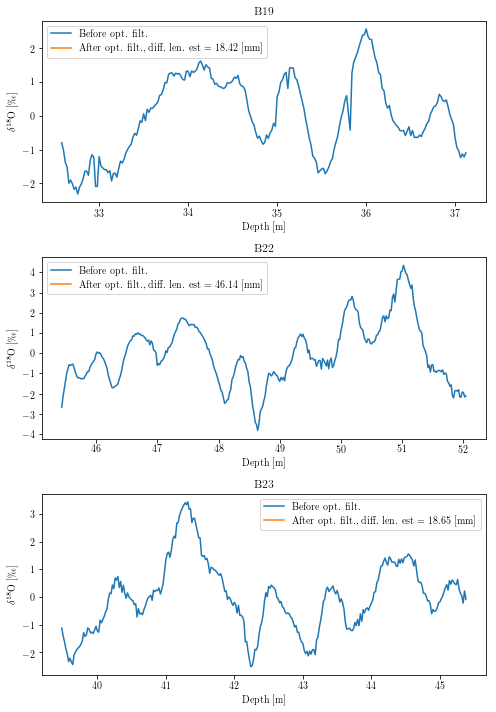

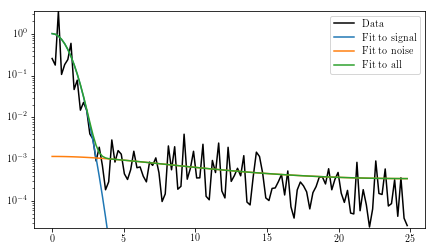

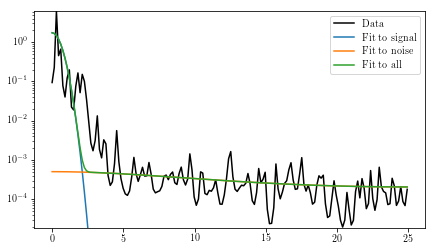

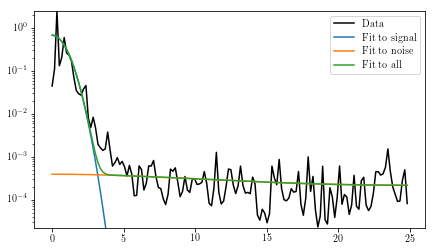

In [4]:
from WienerFilter import WienerFilter
idxs = [0,1,2]
bars = [5,5,5]
Ms = [100,100,100]
Ns = [1000,1000,1000]
data = []
coreNames = ['B19', 'B22', 'B23']
figWien, axWien = plt.subplots(3, 1 , figsize = (7,10))
axWien[-1].set(xlabel='depth [m]')

for idx in idxs:
    d18O_data1 = np.copy(np.array(dfs_LT[idx][0]['d18O']))
    depth_data1 = np.copy(np.array(dfs_LT[idx][0]['depth']))

    Wiener_inst = WienerFilter(name='B19', depth_data=depth_data1, d18O_data=d18O_data1, N=np.size(d18O_data1), M = Ms[idx], bar=bars[idx],view_PSD=False, view_fit=True, view_decon=False)
    data.append(Wiener_inst())
    
    axWien[idx].plot(depth_data1, d18O_data1, label='Before opt. filt.')
    axWien[idx].plot(data[idx][0], data[idx][1], label=f'After opt. filt., diff. len. est = {data[idx][2][3]*1000:.2f} [mm]')
    axWien[idx].set(ylabel='$\delta^{18}$O [\permil]', xlabel='Depth [m]', title=coreNames[idx])
    axWien[idx].legend(loc='best')
figWien.tight_layout()

figWien.savefig('deconvoluted__B19_B22_B23.eps')

In [5]:
data[0][2]

[0.028925977566175057,
 -0.2962921845087352,
 1.0179307556772725,
 0.018421367696563752]

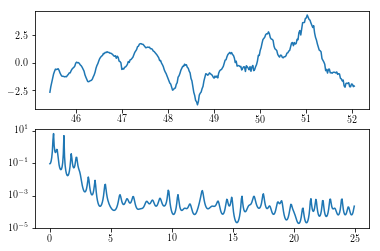

In [6]:
idx = 1


t_data1 = np.copy(np.array(dfs_LT[idx][0]['depth']))
y_data1 = np.copy(np.array(dfs_LT[idx][0]['d18O']))

MEMinst = MEM(t_data = t_data1, y_data = np.copy(y_data1), M = 100)
MEM_P = MEMinst(t_data = t_data1, y_data = np.copy(y_data1), M = 100, N = 1000, view = True)



/home/thea/Documents/KUFysik/MesterTesen/Analysis/WienerFilter.py:54: RuntimeWarning: overflow encountered in exp
  return p0 * np.exp(- (2 * np.pi * w)**2 * s_tot2)
/home/thea/Documents/KUFysik/MesterTesen/Analysis/WienerFilter.py:110: RuntimeWarning: divide by zero encountered in true_divide
  transInv = 1/trans
/home/thea/Documents/KUFysik/MesterTesen/Analysis/WienerFilter.py:110: RuntimeWarning: overflow encountered in true_divide
  transInv = 1/trans
/home/thea/Documents/KUFysik/MesterTesen/Analysis/WienerFilter.py:119: RuntimeWarning: invalid value encountered in multiply
  F = np.fft.fft(d18O_data_Filt) * filt[:-1] * transInv[:-1]


Diffusion length estimate (mm): 46.1362

[1.00000000e+000 6.37362985e-001 1.65024092e-001 1.73572749e-002
 7.41633616e-004 1.28727385e-005 9.07666204e-008 2.59989051e-010
 3.02522463e-013 1.42999287e-016 2.74589416e-020 2.14194043e-024
 6.78741903e-029 8.73726705e-034 4.56899028e-039 9.70596082e-045
 8.37588121e-051 2.93627117e-057 4.18153262e-064 2.41907031e-071
 5.68506155e-079 5.42744619e-087 2.10489074e-095 3.31617365e-104
 2.12235802e-113 5.51789846e-123 5.82777048e-133 2.50037328e-143
 4.35793688e-154 3.08553656e-165 8.87470927e-177 1.03693432e-188
 4.92177819e-201 9.49000635e-214 7.43335106e-227 2.36524679e-240
 3.05732744e-254 1.60539211e-268 3.42447474e-283 2.96743003e-298
 1.04457754e-313 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 

/home/thea/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


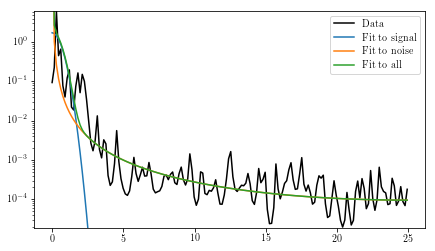

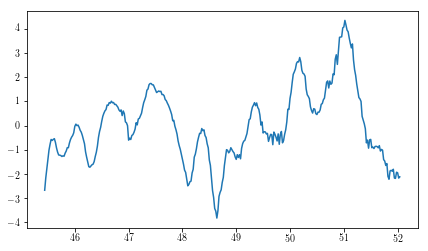

In [7]:
from WienerFilter import WienerFilter
idxs = [0,1,2]
bars = [3,3.5,3.5]
Ms = [100,100,100]
Ns = [1000,1000,1000]
Wiener_inst = WienerFilter(name='B19', depth_data=np.copy(t_data1), d18O_data=np.copy(y_data1),N=np.size(y_data1), M=Ms[idx], bar=bars[idx],view_PSD=False, view_fit=True, view_decon=True)
test = Wiener_inst()

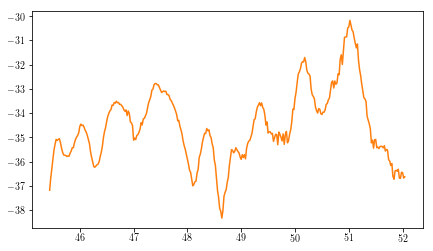

In [8]:
figMEM, axMEM = plt.subplots(figsize=(7,4))
axMEM.plot(test[0], test[1]+np.mean(y_data1))
axMEM.plot(t_data1, y_data1)

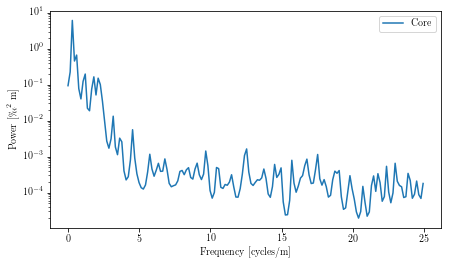

In [9]:
def calc_PSD(depth_data, d18O_data, M_in, N_in, view_PSD):
    MEM_instance = MEM(t_data = depth_data, y_data = d18O_data, M = M_in)
    MEM_power = MEM_instance(t_data = depth_data, y_data = d18O_data, M = M_in, N = N_in, view = False)

    if view_PSD:
        figPSD, axPSD = plt.subplots(figsize = (7,4))
        axPSD.set(xlabel = 'Frequency [cycles/m]', ylabel = r'Power [$\permil ^2$ m]')
        axPSD.semilogy(MEM_power[0], MEM_power[1], label = 'Core')
        axPSD.legend()

    return MEM_power
depth_data1 = np.copy(np.array(dfs_LT[idx][0]['depth']))
d18O_data1 = np.copy(np.array(dfs_LT[idx][0]['d18O']))

test = calc_PSD(depth_data1, d18O_data1, 100,len(d18O_data1),True)

/home/thea/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


619.4738516115893
Diffusion length estimate (mm): 46.2247



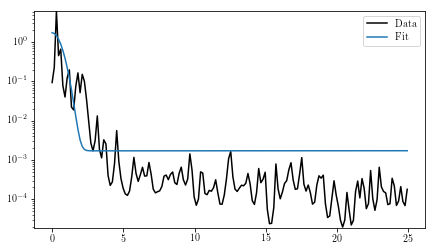

In [10]:
from scipy.optimize import curve_fit


def fit_PSD(depth_data, d18O_data, M_in, N_in, view_PSD, view, print_DiffLen):

    def func(w, s_eta2, a1, p0, s_tot2):
        dz = 0.02
        return p0 * np.exp(- (2 * np.pi * w)**2 * s_tot2) \
                + (s_eta2 * dz) / (abs(1 + a1 * np.exp(- 2 * np.pi * 1j * w * dz))**2)
    
    x_All = calc_PSD(depth_data, d18O_data, M_in, N_in, view_PSD)[0]
    y_All = calc_PSD(depth_data, d18O_data, M_in, N_in, view_PSD)[1]

    popt, pvoc = curve_fit(func, x_All, y_All)
    
    s_eta2_est = popt[0]
    a1_est = popt[1]
    p0_est = popt[2]
    s_tot2_est = popt[3]
    
    fit_params = [s_eta2_est, a1_est, p0_est, s_tot2_est]
    
    if print_DiffLen:
        print(a1_est)
        print(f'Diffusion length estimate (mm): {s_tot2_est*1000:.4f}\n')
    
    y_est = func(x_All, s_eta2_est, a1_est, p0_est, s_tot2_est)
        
    
    if view:
        figFit, axFit = plt.subplots(figsize=(7,4))
        axFit.semilogy(x_All, y_All, color='k', label='Data')
        axFit.semilogy(x_All, y_est, label='Fit')
        axFit.legend()
        axFit.set_ylim((np.min(y_All)-np.min(y_All)/20,np.max(y_All)+np.max(y_All)/20))
    
    return x_All, y_est, fit_params
    
test2 = fit_PSD(depth_data1, d18O_data1, 100, len(d18O_data1), False, True, True)
    


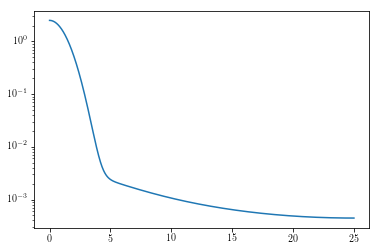

In [11]:
def func(w, s_eta2, a1, p0, s_tot2):
    dz = 0.02
    return p0 * np.exp(- (2 * np.pi * w)**2 * s_tot2) \
                + (s_eta2 * dz) / (abs(1 + a1 * np.exp(- 2 * np.pi * 1j * w * dz))**2)
x = np.linspace(0,25,1000)
y = func(x,0.05,-0.5,2.5,0.01)

plt.semilogy(x,y)